In [3]:
!pip install --extra-index-url=https://pypi.nvidia.com cudf-cu12

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 124.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 MB 71.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.9/527.9 kB 252.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 122.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 216.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 207.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 221.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 MB 172.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.0/193.0 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 107.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 453.8/453.8 kB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Mon_Oct_24_19:12:58_PDT_2022
Cuda compilation tools, release 12.0, V12.0.76
Build cuda_12.0.r12.0/compiler.31968024_0


In [2]:
!nvidia-smi

Wed Apr 23 05:43:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A4000               Off |   00000000:00:05.0 Off |                  Off |
| 41%   43C    P8             17W /  140W |       2MiB /  16376MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [11]:
%load_ext cudf.pandas  

In [3]:
!python --version

Python 3.11.7


In [4]:
import pandas as pd
from datetime import datetime

# Load index and option data
df_index = pd.read_csv("full-nifty-spot.csv", parse_dates=[['date', 'time']])
df_option = pd.read_csv("full-nifty-options.csv", parse_dates=[['date', 'time']])

# Parse expiry and strike from option symbol
def parse_option_symbol(symbol):
    # Example: BANKNIFTY31AUG2337500CE
    expiry_str = symbol[len("BANKNIFTY"):len("BANKNIFTY")+7]
    strike_str = ''.join(filter(str.isdigit, symbol.split("BANKNIFTY")[1]))
    expiry_date = datetime.strptime(expiry_str, "%d%b%y")
    strike = float(strike_str[:-2])  # remove 'CE'
    return pd.Series([expiry_date, strike])

df_option[['expiry', 'strike']] = df_option['symbol'].apply(parse_option_symbol)

/tmp/ipykernel_12997/1526350114.py:5: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df_index = pd.read_csv("full-nifty-spot.csv", parse_dates=[['date', 'time']])
/tmp/ipykernel_12997/1526350114.py:6: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df_option = pd.read_csv("full-nifty-options.csv", parse_dates=[['date', 'time']])


In [5]:
# Merge based on datetime
df_merged1 = pd.merge_asof(
    df_option.sort_values("date_time"),
    df_index.sort_values("date_time"),
    on="date_time",
    tolerance=pd.Timedelta("5min"),
    direction='nearest'
)

# Compute time to maturity T - t in years
df_merged1["t"] = (df_merged1["expiry"] - df_merged1["date_time"]).dt.total_seconds() / (365 * 24 * 3600)
df_merged1 = df_merged1[df_merged1["t"] > 0]  # Remove expired

In [6]:
df_merged1.shape


(7960225, 16)

In [7]:
bf=df_merged1.dropna()

In [8]:
bf.shape

(7960225, 16)

In [73]:
df_merged=df_merged1.head(100000)

In [74]:
import torch
import torch.nn as nn

class EuropeanCall_gated1(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super(EuropeanCall_gated1, self).__init__()
        self.N_HIDDEN = N_HIDDEN
        self.activation1 = nn.LeakyReLU(negative_slope=0.2)
        self.activation2 = nn.Tanh()
        self.fcs1 = nn.Sequential(
            nn.Linear(N_INPUT, N_HIDDEN),
            self.activation2)
        self.fcs2 = nn.Sequential(
            nn.Linear(N_INPUT, N_OUTPUT),
            self.activation2)
        self.fch = nn.Sequential(*[
            nn.Sequential(
                nn.Linear(N_HIDDEN, N_HIDDEN),
                self.activation2
            ) for _ in range(N_LAYERS)])
        self.fce = nn.Sequential(*[nn.Linear(N_HIDDEN, N_OUTPUT)])
        self.w1_layer = nn.Sequential(*[nn.Linear(N_HIDDEN + N_INPUT, N_OUTPUT),self.activation2])
        self.w2_layer = nn.Sequential(*[nn.Linear(N_HIDDEN + N_INPUT, N_OUTPUT),self.activation2])

    def forward(self, x):
        # Apply the first layer
        I1 = self.fcs1(x)
        H = I1
        # Apply hidden layers with residual connections
        for layer in self.fch:
            H = layer(H) + H
        # Apply the final layer
        yx = self.fcs2(x) #1D
        yh =  self.fce(H)#1D
        h_x = torch.cat([H,x],axis=1)
        wx = self.w1_layer(h_x)
        wh = self.w2_layer(h_x)
        y_net = wx*yx + wh*yh
        return y_net

In [75]:
class EuropeanCall_gated1(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super(EuropeanCall_gated1, self).__init__()
        self.N_HIDDEN = N_HIDDEN
        self.activation1 = nn.LeakyReLU(negative_slope=0.2)
        self.activation2 = nn.Tanh()
        self.fcs1 = nn.Sequential(
            nn.Linear(N_INPUT, N_HIDDEN),
            self.activation2)
        self.fcs2 = nn.Sequential(
            nn.Linear(N_INPUT, N_HIDDEN),
            self.activation2)
        self.fch = nn.Sequential(*[
            nn.Sequential(
                nn.Linear(N_HIDDEN, N_HIDDEN),
                self.activation2
            ) for _ in range(N_LAYERS)])
        self.fce1 = nn.Sequential(*[nn.Linear(N_HIDDEN, N_OUTPUT)])
        self.fce2 = nn.Sequential(*[nn.Linear(N_HIDDEN, N_OUTPUT)])
        self.w1_layer = nn.Sequential(*[nn.Linear(N_HIDDEN + N_HIDDEN, N_OUTPUT),self.activation2])
        self.w2_layer = nn.Sequential(*[nn.Linear(N_HIDDEN + N_HIDDEN, N_OUTPUT),self.activation2])
        # init.xavier_uniform_(self.fcs1.weight)
        # init.xavier_uniform_(self.fcs2.weight)
        # init.xavier_uniform_(self.fch.weight)

    def forward(self, x):
        # Apply the first layer
        I1 = self.fcs1(x)
        H1 = I1
        # Apply hidden layers with residual connections
        for layer in self.fch:
            H1 = layer(H1) + H1
        # Apply the final layer
        H2 = self.fcs2(x) #1
        y1 =  self.fce1(H1)#1D
        y2 =  self.fce2(H2)#1D
        H_cat = torch.cat([H1,H2],axis=1)
        # print (h_x.shape)
        w1 = self.w1_layer(H_cat)
        w2 = self.w2_layer(H_cat)
        y_net = w1*y1 + w2*y2
        return y_net

In [76]:
import torch
import torch.nn as nn
import torch.optim as optim

# Hyperparameters
N_EPOCH = 25000
LEARNING_RATE = 1e-4
HIDDEN_LAYER = 2
HIDDEN_WIDTH = 128
PHYSICS_PENALTY = 50
BVP1_PENALTY = 7
DEVICE=device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [77]:
print(DEVICE)

cuda


In [78]:
model = EuropeanCall_gated1(3, 1, HIDDEN_WIDTH, HIDDEN_LAYER).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.MSELoss()


In [79]:
S = torch.tensor(df_merged["close_y"].values).float().view(-1, 1).to(DEVICE)  # Index close
K = torch.tensor(df_merged["strike"].values).float().view(-1, 1).to(DEVICE)
t = torch.tensor(df_merged["t"].values).float().view(-1, 1).to(DEVICE)
V = torch.tensor(df_merged["close_x"].values).float().view(-1, 1).to(DEVICE)  # Option close


In [80]:
# Min-Max Normalization (scale to [0, 1])
t_min, t_max = t.min(), t.max()
S_min, S_max = S.min(), S.max()
K_min, K_max = K.min(), K.max()


t_norm = (t - t_min) / (t_max - t_min)
S_norm = (S - S_min) / (S_max - S_min)
K_norm = (K - K_min) / (K_max - K_min)

Y_min, Y_max = V.min(), V.max()
V_norm=(V-Y_min)/(V+Y_min)
# Concatenate normalized inputs
X1 = torch.cat([t_norm, S_norm, K_norm], dim=1).to(DEVICE)
X1.requires_grad_(True)

# Target remains the same
y1 = torch.cat([V_norm], dim=1).to(DEVICE)


In [81]:
V.shape

torch.Size([100000, 1])

In [70]:
for epoch in range(N_EPOCH):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    V_pred = model(X1)
    # if not epoch%1000:
    #     print(V_pred,y1)

    # Compute losses
    mse_data = loss_fn(V_pred, y1)

    # Compute derivatives for physics loss
    grads = torch.autograd.grad(V_pred, X1, grad_outputs=torch.ones_like(V_pred), retain_graph=True, create_graph=True)[0]
    dVdt, dVdS = grads[:, 0].view(-1, 1), grads[:, 1].view(-1, 1)
    grads2nd = torch.autograd.grad(dVdS, X1, grad_outputs=torch.ones_like(dVdS), create_graph=True)[0]
    d2VdS2 = grads2nd[:, 1].view(-1, 1)

    # Black-Scholes PDE residual
    sigma = 0.3972855052630831
    r = 0.0633
    bs_pde = dVdt + 0.5 * (sigma * S) ** 2 * d2VdS2 + r * S * dVdS - r * V_pred
    loss_physics = PHYSICS_PENALTY * loss_fn(bs_pde, torch.zeros_like(bs_pde))*100

    # Total loss
    loss = mse_data #+ loss_physics

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Logging
    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch+1}, Total Loss: {loss.item():.4f}, Data Loss: {mse_data.item():.4f}, Physics Loss: {loss_physics.item():.4f}")

Epoch 500, Total Loss: 155297.6406, Data Loss: 155297.6406, Physics Loss: 26176146013375967526912.0000
Epoch 1000, Total Loss: 152115.7344, Data Loss: 152115.7344, Physics Loss: 271643204392940489146368.0000
Epoch 1500, Total Loss: 148656.3750, Data Loss: 148656.3750, Physics Loss: 839841706863185593630720.0000
Epoch 2000, Total Loss: 145357.4688, Data Loss: 145357.4688, Physics Loss: 1116227327764536781438976.0000


KeyboardInterrupt: 

In [82]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Hyperparams
N_EPOCH = 15000
PHYSICS_PENALTY = 50  # You can adjust this
learning_rate = 1e-3
sigma = 0.3972855052630831
r = 0.0633

# Store losses
losses = {
    "mse": [],
    "pde": [],
    "hybrid": [],
}

# Store predictions
predictions = {
    "mse": None,
    "pde": None,
    "hybrid": None,
}




In [83]:
def train_model(model, optimizer, loss_fn, mode):
    model.to(DEVICE)
    model.train()
    history = []

    for epoch in range(N_EPOCH):
        optimizer.zero_grad()
        y1_hat = model(X1)

        # DATA LOSS
        mse_data = loss_fn(y1_hat, y1)
        if not epoch%1000:
            print(y1_hat,y1)

        # PHYSICS LOSS
        grads = torch.autograd.grad(
            y1_hat, X1,
            grad_outputs=torch.ones_like(y1_hat).to(X1.device),
            retain_graph=True,
            create_graph=True,
            only_inputs=True
        )[0]
        dVdt, dVdS = grads[:, 0:1], grads[:, 1:2]
        grads2nd = torch.autograd.grad(
            dVdS, X1,
            grad_outputs=torch.ones_like(dVdS).to(X1.device),
            create_graph=True,
            only_inputs=True
        )[0]
        d2VdS2 = grads2nd[:, 1:2]
        S1 = X1[:, 1:2]
        bs_pde = dVdt + 0.5 * ((sigma * S1) ** 2) * d2VdS2 + r * S1 * dVdS - r * y1_hat
        loss_physics = nn.MSELoss()(bs_pde, torch.zeros_like(bs_pde))

        # TOTAL LOSS
        if mode == "mse":
            loss = mse_data
        elif mode == "pde":
            loss = PHYSICS_PENALTY * loss_physics
        elif mode == "hybrid":
            loss = mse_data + PHYSICS_PENALTY * loss_physics

        loss.backward()
        optimizer.step()
        history.append(loss.item())

        if (epoch + 1) % 500 == 0:
            print(f"[{mode.upper()}] Epoch {epoch+1}, Loss: {loss.item():.4f}")

    return history, model(X1).detach().cpu()


In [84]:
model_mse = EuropeanCall_gated1(3, 1, HIDDEN_WIDTH, HIDDEN_LAYER).to(DEVICE)
opt_mse = torch.optim.Adam(model_mse.parameters(), lr=learning_rate)
losses["mse"], predictions["mse"] = train_model(model_mse, opt_mse, nn.MSELoss(), mode="mse")

model_pde = EuropeanCall_gated1(3, 1, HIDDEN_WIDTH, HIDDEN_LAYER).to(DEVICE)
opt_pde = torch.optim.Adam(model_pde.parameters(), lr=learning_rate)
losses["pde"], predictions["pde"] = train_model(model_pde, opt_pde, nn.MSELoss(), mode="pde")

# === TRAIN HYBRID ===
model_hybrid = EuropeanCall_gated1(3, 1, HIDDEN_WIDTH, HIDDEN_LAYER).to(DEVICE)
opt_hybrid = torch.optim.Adam(model_hybrid.parameters(), lr=learning_rate)
losses["hybrid"], predictions["hybrid"] = train_model(model_hybrid, opt_hybrid, nn.MSELoss(), mode="hybrid")

tensor([[-0.2459],
        [-0.2455],
        [-0.2433],
        ...,
        [-0.0223],
        [-0.0210],
        [-0.0235]], device='cuda:0', grad_fn=<AddBackward0>) tensor([[0.6649],
        [0.8301],
        [0.9836],
        ...,
        [0.9877],
        [0.8956],
        [0.8994]], device='cuda:0')
[MSE] Epoch 500, Loss: 0.0061
[MSE] Epoch 1000, Loss: 0.0038
tensor([[0.6187],
        [0.8093],
        [0.9874],
        ...,
        [1.0023],
        [0.9612],
        [0.9446]], device='cuda:0', grad_fn=<AddBackward0>) tensor([[0.6649],
        [0.8301],
        [0.9836],
        ...,
        [0.9877],
        [0.8956],
        [0.8994]], device='cuda:0')
[MSE] Epoch 1500, Loss: 0.0037
[MSE] Epoch 2000, Loss: 0.0037
tensor([[0.6179],
        [0.8139],
        [0.9871],
        ...,
        [0.9869],
        [0.9577],
        [0.9380]], device='cuda:0', grad_fn=<AddBackward0>) tensor([[0.6649],
        [0.8301],
        [0.9836],
        ...,
        [0.9877],
        [0.8956],
 

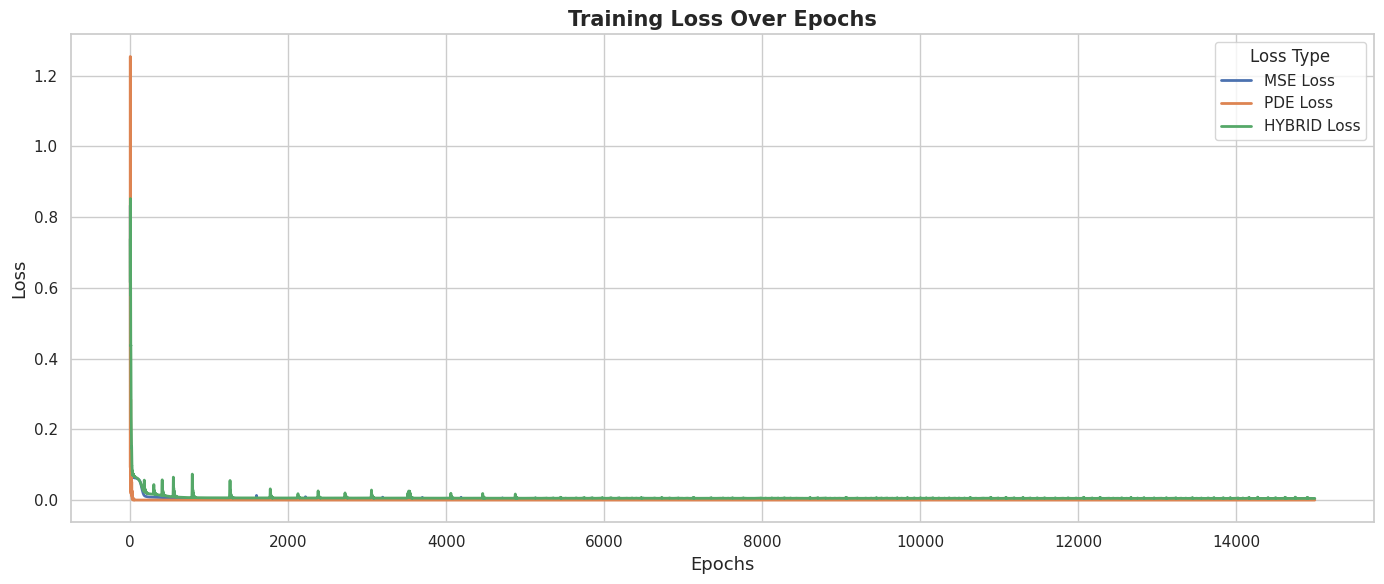

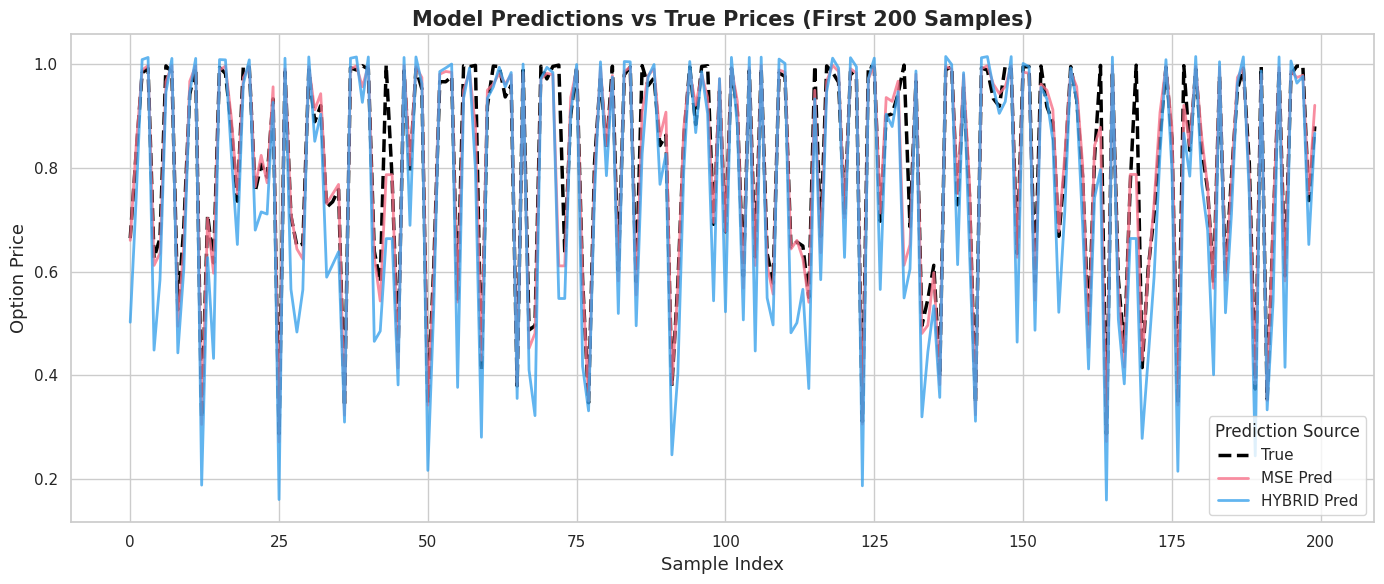

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a clean style
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 12})

# =============================
# === PLOTTING RESULTS ========
# =============================

# 1. Loss Curves
plt.figure(figsize=(14, 6))
for k in losses:
    plt.plot(losses[k], label=f"{k.upper()} Loss", linewidth=2)

plt.xlabel("Epochs", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.title("Training Loss Over Epochs", fontsize=15, weight='bold')
plt.legend(title="Loss Type", fontsize=11)
plt.tight_layout()
plt.show()


# 2. Prediction Comparison (First 200 Samples)
plt.figure(figsize=(14, 6))

# True values
true_vals = y1.detach().cpu().numpy()
plt.plot(true_vals[:200], label="True", color="black", linewidth=2.5, linestyle='--')

# Predicted values
colors = sns.color_palette("husl", len(predictions))
for i, k in enumerate(predictions):
    if k!="pde": plt.plot(predictions[k][:200], label=f"{k.upper()} Pred", alpha=0.8, linewidth=2, color=colors[i])

plt.title("Model Predictions vs True Prices (First 200 Samples)", fontsize=15, weight='bold')
plt.xlabel("Sample Index", fontsize=13)
plt.ylabel("Option Price", fontsize=13)
plt.legend(title="Prediction Source", fontsize=11)
plt.tight_layout()
plt.show()

In [99]:
torch.save(model_hybrid.state_dict(), 'model_weights.pth')